In [ ]:
## To access Global Flood Database Data, run:
# gsutil -m cp -r gs://gfd_v1_4 "your\local\repository"
## Install gsutil first: https://cloud.google.com/storage/docs/gsutil_install
## GFD repo is available at: https://github.com/cloudtostreet/MODIS_GlobalFloodDatabase

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from dask.diagnostics import ProgressBar
from geocube.api.core import make_geocube

PATH = "D:\World Bank\CLIENT v2"
DATA_RAW = rf"{PATH}\Data\Data_raw"
DATA_PROC = rf"{PATH}\Data\Data_proc"
DATA_OUT = rf"{PATH}\Data\Data_out"

c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\cupy\_environment.py:216: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [2]:
import os
from tqdm import tqdm

def load_population_data(bounds=None, generate=False):
    print("Processing Population data...")

    # Select all files in GPW folder
    gpw_path = r"Z:\WB Data\Gridded Population of The World (GPWv4)"
    files = os.listdir(gpw_path)
    files = [f for f in files if f.endswith(".tif")]
    
    # Compile into a single dataset
    dss = []
    for f in tqdm(files):
        
        ds = xr.open_dataset(os.path.join(gpw_path, f), chunks={"x": 10000, "y": 10000})
        ds["band_data"] = ds["band_data"].astype(np.uint32)
        if bounds is not None:
            ds = ds.sel(
                x=slice(bounds[0], bounds[2]), y=slice(bounds[3], bounds[1])
            )
        if generate:
            with ProgressBar():
                ds.sel(band=1).drop_vars("band").band_data.rio.to_raster(rf"E:\client_v2_data\{f.replace('.tif','_proc.tif')}")
                print(f"Saved {f.replace('.tif','_proc.tif')}")
        
        ds["year"] = int(f.split("_")[5])
        ds = ds.set_coords('year')
        dss += [ds]
        
    population = xr.concat(dss, dim="year")    
    
    # Filter if bounds are provided
    if bounds is not None:
        population = population.sel(
            x=slice(bounds[0], bounds[2]), y=slice(bounds[3], bounds[1])
        )
        
    # Clean band dimension
    population = population.sel(band=1).drop_vars(["band"])
    
    print("Done!")
    return population


In [3]:
pop = load_population_data(bounds=None, generate=False)

Processing Population data...


  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:159: RuntimeWarning: 'ee' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
 20%|██        | 1/5 [00:03<00:12,  3.12s/it]c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:159: RuntimeWarning: 'ee' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:159: RuntimeWarning: 'ee' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
c:\Users\ofici\

Done!


In [34]:
import json
import re 
from datetime import datetime

def extract_number_from_filename(filename):
    # Define the regex pattern to extract the number
    match = re.search(r'DFO_(\d+)_', filename)
    if match:
        assert len(match.groups()) == 1
        return int(match.group(1))
    return None

def extract_year_from_filename(filename):
    import re

    year = None
    # Define a regular expression pattern to match the dates
    pattern = r'From_(\d{8})_to_(\d{8})'

    # Use re.search to find the dates in the string
    match = re.search(pattern, filename)

    if match:
        # Extract the dates from the matched groups
        date_from = match.group(1)
        date_to = match.group(2)
        
        # Convert to a more readable format if needed
        # Convert strings to datetime.date objects
        date_from_dt = datetime.strptime(date_from, r'%Y%m%d').date()
        date_to_dt = datetime.strptime(date_to, r'%Y%m%d').date()

        # Calculate the average date
        average_date = date_from_dt + (date_to_dt - date_from_dt) / 2
        average_date = average_date.strftime(r'%Y-%m-%d')
        year = average_date.split("-")[0]
    else:
        print("Dates not found in the string.")

    return year


def check_word_in_json_files(directory, word):
    word = word.upper()
    files_checked = 0
    files_containing_word = []
    
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            files_checked += 1
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                data = json.load(file)
                
                # Check if the word is in any of the values
                for value in data.values():
                    if isinstance(value, str) and word in value.upper():
                        files_containing_word += [filepath]
                        break
                    elif isinstance(value, list) and any(word in str(item).upper() for item in value):
                        files_containing_word += [filepath]
                        break
    
    print(f"Files checked: {files_checked}")
    print(f"Files containing '{word_to_check}': {len(files_containing_word)}")
    
    ids = [extract_number_from_filename(f) for f in files_containing_word]
    return ids

directory = r'Z:\WB Data\Global Flood Database\gfd_v1_4'  # Replace with the path to your JSON files
word_to_check = 'INDIA'
containing = check_word_in_json_files(directory, word_to_check)

Files checked: 913
Files containing 'INDIA': 149


In [6]:
def process_gdw_file(ds):
    masked = xr.where(ds.sel(band=5)==1, 0, ds.sel(band=1))
    masked["band_data"] = masked["band_data"].fillna(0).astype(bool)
    return masked

In [38]:
files = os.listdir(directory)
files = [f for f in files if f.endswith(".tif")]
# Keep only those files that contain the id in the filename
# files = [f for f in files if extract_number_from_filename(f) in containing]
# assert len(files) == len(containing)

pop_to_fill = xr.zeros_like(pop.sel(year=2000))

tasks = []
for i, f in tqdm(enumerate(files), total=len(files)):
    year = extract_year_from_filename(f)
    shockid = extract_number_from_filename(f)
    ds = xr.open_dataset(os.path.join(directory, f), engine="rasterio", chunks={"x": 500, "y": 500})
    ds = process_gdw_file(ds)
    # x_bounds = slice(ds.x.min(), ds.x.max())
    # y_bounds = slice(ds.y.max(), ds.y.min())
    # pop_slice = pop.sel(year=2000, x=x_bounds, y=y_bounds)
    ds_aggregated = ds.interp_like(pop_to_fill, method="linear")
    ds_aggregated = ds_aggregated.assign_coords({"year": year})
    ds_aggregated = ds_aggregated.assign_coords({"id": shockid})
    ds_aggregated = ds_aggregated.to_netcdf(os.path.join(DATA_PROC, "GFD", f"{f.replace('.tif', f'_proc.nc')}"), compute=False)
    tasks += [ds_aggregated]

  5%|▌         | 51/937 [00:06<01:29,  9.91it/s]c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\core\indexing.py:1622: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
  8%|▊         | 74/937 [00:09<01:44,  8.23it/s]c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\core\indexing.py:1622: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, s

In [25]:
def is_regular_grid(ds):
    # Assuming the coordinates are named 'lat' and 'lon'
    lat = ds.coords['y'].values
    lon = ds.coords['x'].values
    
    # Check if the latitude and longitude differences are uniform
    lat_diff = np.diff(lat)
    lon_diff = np.diff(lon)
    
    # A grid is regular if the differences are all the same
    is_lat_regular = np.allclose(lat_diff, lat_diff[0])
    is_lon_regular = np.allclose(lon_diff, lon_diff[0])
    
    return is_lat_regular & is_lon_regular

In [40]:
import dask

with ProgressBar():
    dask.compute(*tasks)

[###########################             ] | 69% Completed | 3hr 8mms


RasterioIOError: Read or write failed. Z:/WB Data/Global Flood Database/gfd_v1_4/DFO_1921_From_20020507_to_20020606.tif, band 1: IReadBlock failed at X offset 10, Y offset 9: TIFFReadEncodedTile() failed.

In [26]:
# dss = xr.align(*dss, join="outer")
ds_full = xr.concat(dss, dim="time")
# Compute max affected per year
ds_full = ds_full.groupby('time.year').mean('time')

KeyboardInterrupt: 

In [ ]:
with ProgressBar():
    ds_full.to_netcdf(rf"{DATA_PROC}\gfd_v1_4_max.nc")

In [201]:
for ds in out:
    print(is_regular_grid(ds))

True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
test = xr.open_dataset(rf"Z:\WB Data\Global Flood Database\gfd_v1_4\DFO_1972_From_20020630_to_20020723.tif")
masked = xr.where(test.sel(band=5)==1, 0, test.sel(band=1))
masked.band_data.to_netcdf("test2.nc")

In [ ]:
(test.sel(band=1) - test.sel(band=5))

In [8]:
def get_bounds_from_chunk_number(chunk_number, total_chunks=8):
    """Get the bounding box coordinates for a given chunk number.

    Data is divided into total_chunks chunks, each covering an 1/total_chunks of the globe.

    Parameters:
    -----------
    chunk_number: int
        Chunk number < total_chunks.
    total_chunks: int
        Total number of chunks to divide the globe into.

    Returns:
    --------
    tuple: Bounding box coordinates (left, bottom, right, top).
    """

    if chunk_number > total_chunks - 1:
        raise ValueError("Chunk number must be less than total_chunks.")

    # Define the bounding box coordinates for each chunk
    x_min = -180
    x_max = 180
    y_min = -90
    y_max = 90

    # Calculate the bounding box coordinates for the given chunk number
    side_chunks = np.sqrt(total_chunks)
    if not side_chunks.is_integer():
        raise ValueError("Total chunks must be a square number.")
    side_chunks = int(side_chunks)

    chunk_position = np.unravel_index(chunk_number, (side_chunks, side_chunks))

    x_step = (x_max - x_min) / side_chunks
    y_step = (y_max - y_min) / side_chunks

    left = x_min + chunk_position[0] * x_step
    right = left + x_step
    bottom = y_min + chunk_position[1] * y_step
    top = bottom + y_step

    return (left, bottom, right, top)


In [58]:
merged

,ID,OBJECTID,ADM2_CODE,ADM2_NAME,ADM1_CODE,ADM1_NAME,ADM0_CODE,ADM0_NAME,ADMLAST_CODE,ADMLAST_NAME,geometry,area_affected,cells_affected,total_cells,population_affected,population_affected_n,total_population
96,96,13798.0,NaN,Administrative unit not available,574,Administrative unit not available,22,Baker Island (U.S.),574.0,Administrative unit not available,"POLYGON ((-176.47550 0.18995, -176.47652 0.189...",0.000000,0.000000,2,NaN,0.0,0
130,130,10353.0,NaN,Administrative unit not available,932,Administrative unit not available,55,Clipperton Island (Fr.),932.0,Administrative unit not available,"POLYGON ((-109.21324 10.28733, -109.21437 10.2...",0.000000,0.000000,11,NaN,0.0,0
216,216,10362.0,NaN,Administrative unit not available,1439,Administrative unit not available,112,Howland Island (U.S.),1439.0,Administrative unit not available,"POLYGON ((-176.61600 0.81568, -176.61498 0.813...",0.000000,0.000000,2,NaN,0.0,0
319,319,13802.0,NaN,Administrative unit not available,1700,Administrative unit not available,129,Johnston Atoll (U.S.),1700.0,Administrative unit not available,"MULTIPOLYGON (((-169.52113 16.73715, -169.5210...",0.000000,0.000000,5,NaN,0.0,0
322,322,10654.0,NaN,Administrative unit not available,1738,Administrative unit not available,134,Kingman Reef (U.S.),1738.0,Administrative unit not available,"MULTIPOLYGON (((-162.83349 6.22525, -162.82466...",0.000000,0.000000,391,NaN,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37388,37388,13791.0,154738.0,Adams,3219,Colorado,259,United States of America,154738.0,Adams,"POLYGON ((-103.86177 40.00123, -103.86147 40.0...",0.000209,0.959961,4584,NaN,0.0,0
37389,37389,13792.0,154739.0,Boulder,3219,Colorado,259,United States of America,154739.0,Boulder,"MULTIPOLYGON (((-105.05772 39.97236, -105.0577...",0.000022,0.064453,2875,NaN,0.0,0
37390,37390,13793.0,154740.0,Broomfield,3219,Colorado,259,United States of America,154740.0,Broomfield,"MULTIPOLYGON (((-105.09996 39.95785, -105.0998...",0.000000,0.000000,127,NaN,0.0,0
37391,37391,13794.0,154741.0,Jefferson,3219,Colorado,259,United States of America,154741.0,Jefferson,"MULTIPOLYGON (((-105.22234 39.91418, -105.2181...",0.000067,0.207031,3071,NaN,0.0,0


<Axes: >

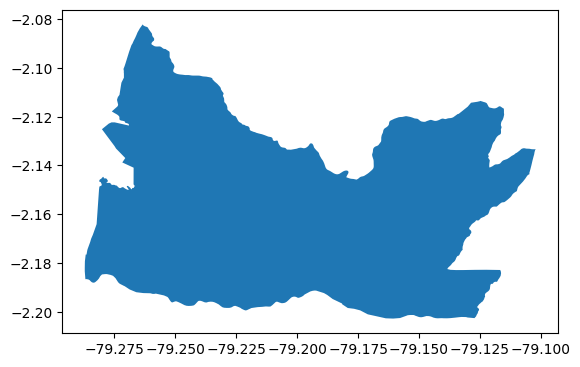

In [65]:
merged[merged.ID == 11800].plot()

In [113]:
190-360

-170

In [134]:
condition

<xarray.DataArray 'x' (x: 3600)> Size: 4kB
array([False, False, False, ...,  True,  True,  True])
Coordinates:
  * x        (x) float64 29kB 0.0 0.1 0.2001 0.3001 ... 359.7 359.8 359.9 360.0

In [144]:
ds

<xarray.Dataset> Size: 13GB
Dimensions:              (y: 1799, x: 3600, year: 51)
Coordinates:
  * x                    (x) float64 29kB -179.9 -179.8 -179.7 ... 179.8 179.9
  * y                    (y) float32 7kB 89.9 89.8 89.7 ... -89.7 -89.8 -89.9
  * year                 (year) int64 408B 1970 1971 1972 ... 2018 2019 2020
Data variables: (12/40)
    drought_SPI-1_1_0    (y, x, year) bool 330MB ...
    drought_SPI-1_1_5    (y, x, year) bool 330MB ...
    drought_SPI-1_2_0    (y, x, year) bool 330MB ...
    drought_SPI-1_2_5    (y, x, year) bool 330MB ...
    drought_SPEI-1_1_0   (y, x, year) bool 330MB ...
    drought_SPEI-1_1_5   (y, x, year) bool 330MB ...
    ...                   ...
    drought_SPI-24_2_0   (y, x, year) bool 330MB ...
    drought_SPI-24_2_5   (y, x, year) bool 330MB ...
    drought_SPEI-24_1_0  (y, x, year) bool 330MB ...
    drought_SPEI-24_1_5  (y, x, year) bool 330MB ...
    drought_SPEI-24_2_0  (y, x, year) bool 330MB ...
    drought_SPEI-24_2_5  (y, x, year) bool 330MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-06-11 19:34:49 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [146]:
ds = xr.open_dataset(r"D:\World Bank\CLIENT v2\Data\Data_out\ERA5_droughts_yearly.nc", chunks={"x": 900, "y": 1800})
def coordinates_from_0_360_to_180_180(ds):
    ds["x"] = ds.x - 180
    ds["x"] = ds.x.where(ds.x > -180, ds.x + 360)
    ds = ds.sortby("x")
    return ds

with ProgressBar():
    ds.to_netcdf(r"D:\World Bank\CLIENT v2\Data\Data_out\ERA5_droughts_yearly_corrected.nc")

# ds.sel(year=2000)["drought_SPI-1_1_0"].plot()

[########################################] | 100% Completed | 153.57 s


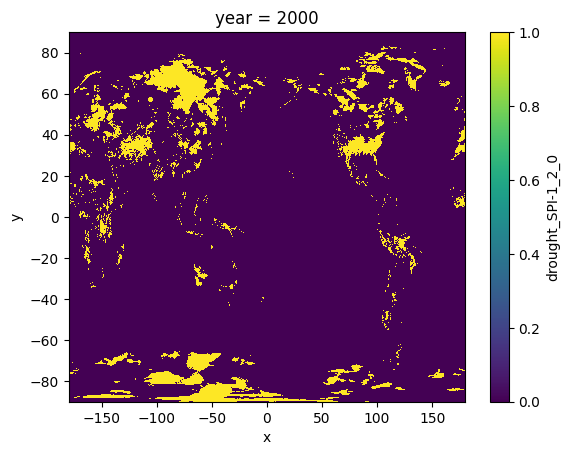

In [88]:
ds = xr.open_dataset(r"D:\World Bank\CLIENT v2\Data\Data_out\ERA5_droughts_yearly.nc")
ds.sel(year=2000)["drought_SPI-1_2_0"].plot()

In [151]:
ds

<xarray.Dataset> Size: 13GB
Dimensions:              (y: 1799, x: 3600, year: 51)
Coordinates:
  * x                    (x) float64 29kB -179.9 -179.8 -179.7 ... 179.8 179.9
  * y                    (y) float32 7kB 89.9 89.8 89.7 ... -89.7 -89.8 -89.9
  * year                 (year) int64 408B 1970 1971 1972 ... 2018 2019 2020
Data variables: (12/40)
    drought_SPI-1_1_0    (y, x, year) bool 330MB ...
    drought_SPI-1_1_5    (y, x, year) bool 330MB ...
    drought_SPI-1_2_0    (y, x, year) bool 330MB ...
    drought_SPI-1_2_5    (y, x, year) bool 330MB ...
    drought_SPEI-1_1_0   (y, x, year) bool 330MB ...
    drought_SPEI-1_1_5   (y, x, year) bool 330MB ...
    ...                   ...
    drought_SPI-24_2_0   (y, x, year) bool 330MB ...
    drought_SPI-24_2_5   (y, x, year) bool 330MB ...
    drought_SPEI-24_1_0  (y, x, year) bool 330MB ...
    drought_SPEI-24_1_5  (y, x, year) bool 330MB ...
    drought_SPEI-24_2_0  (y, x, year) bool 330MB ...
    drought_SPEI-24_2_5  (y, x, year) bool 330MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-06-11 19:34:49 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

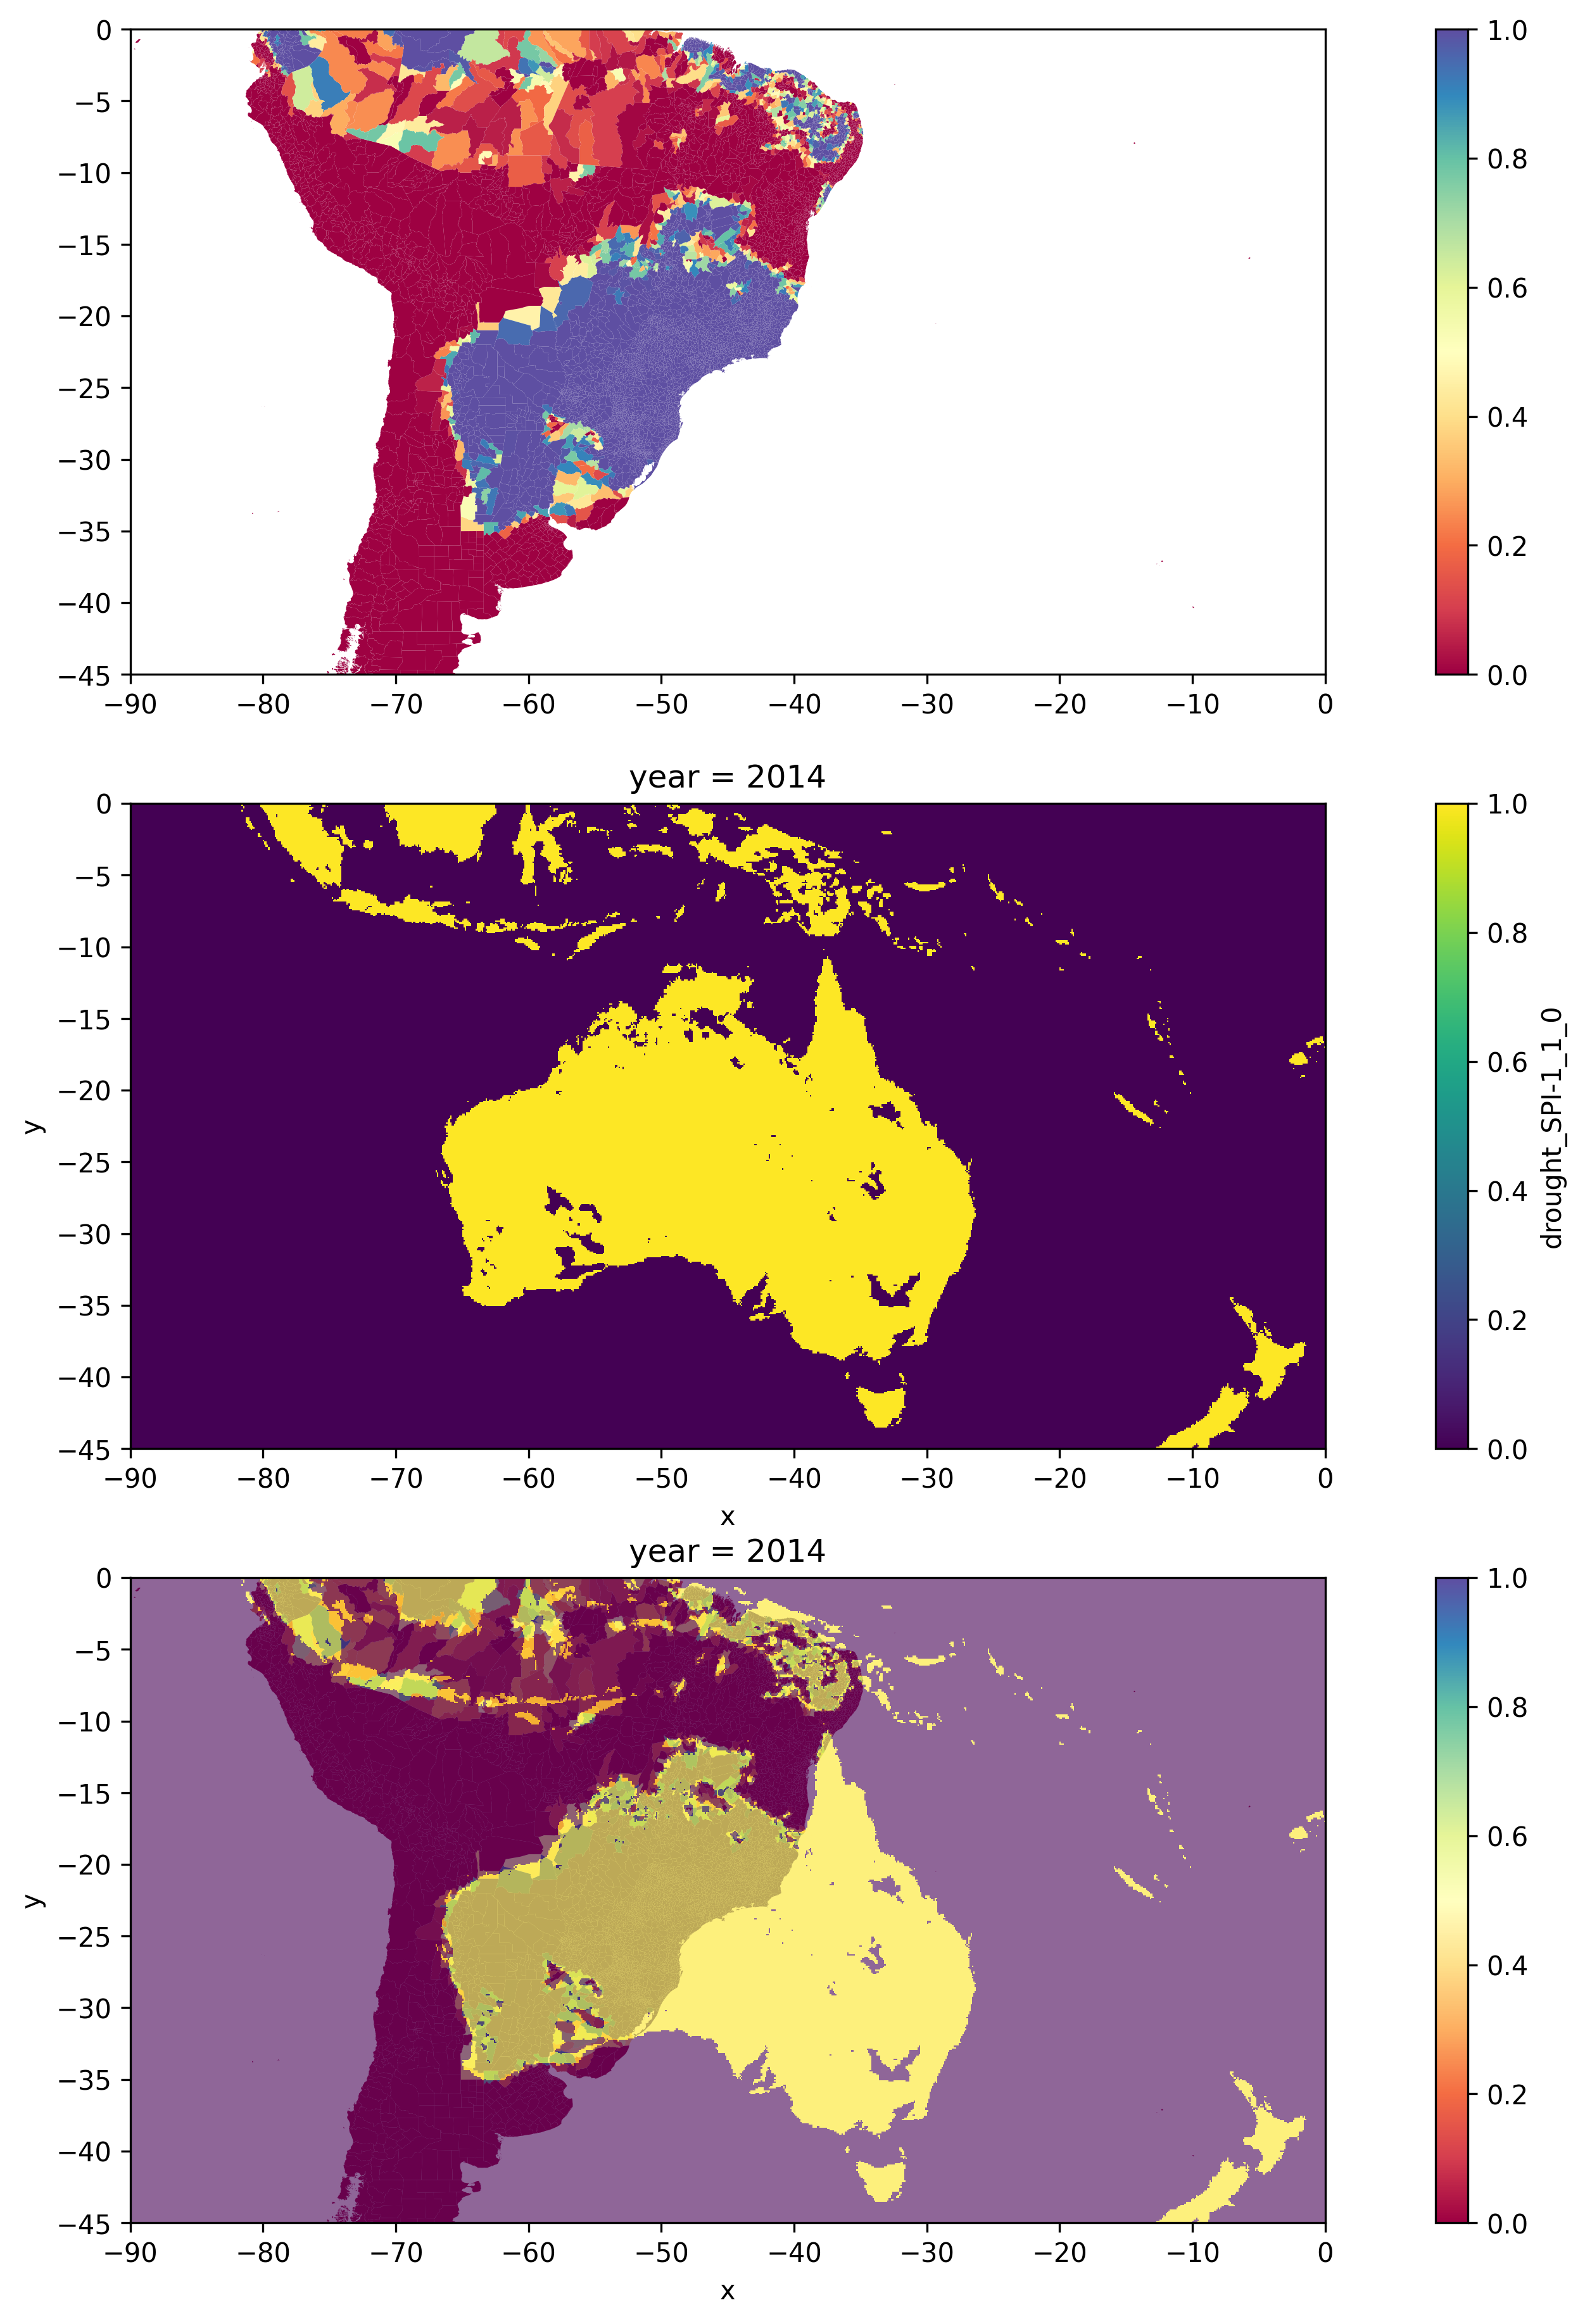

In [83]:
chunk = 5
year = 2014
var = "drought_SPI-1_1_0"

df = pd.read_parquet(rf"D:\World Bank\CLIENT v2\Data\Data_proc\shocks\drought_{var}_{year}_{chunk}_zonal_stats.parquet")
gdf = gpd.read_feather(r"E:\client_v2_data\WB_country_IDs.feather")
merged = gdf.merge(df, left_on="ID", right_index=True, validate="1:1")

ds = xr.open_dataset(r"D:\World Bank\CLIENT v2\Data\Data_out\ERA5_droughts_yearly.nc")
chunk_bounds = get_bounds_from_chunk_number(chunk, 16)
ds = ds.sel(x=slice(chunk_bounds[0], chunk_bounds[2]), y=slice(chunk_bounds[3], chunk_bounds[1]), year=year)

fig, axs = plt.subplots(3, 1, figsize=(15, 15), dpi=300)

# merged.plot(column="area_affected", ax=axs[1])
merged.plot(column="area_affected", ax=axs[0], legend=True, cmap="Spectral")
merged.plot(column="area_affected", ax=axs[1], legend=False, cmap="Spectral", alpha=0)
merged.plot(column="area_affected", ax=axs[2], legend=True, cmap="Spectral")
ds[f"{var}"].plot(ax=axs[1])
ds[f"{var}"].plot(ax=axs[2], add_colorbar=False, alpha=0.6)

for ax in axs:
    ax.set_xlim(chunk_bounds[0], chunk_bounds[2])
    ax.set_ylim(chunk_bounds[1], chunk_bounds[3])


In [77]:
merged

,ID,OBJECTID,ADM2_CODE,ADM2_NAME,ADM1_CODE,ADM1_NAME,ADM0_CODE,ADM0_NAME,ADMLAST_CODE,ADMLAST_NAME,geometry,area_affected,cells_affected,total_cells,population_affected,population_affected_n,total_population
11800,11800,20763.0,15426.0,Gnral. Antonio Elizalde,22005,Guayas,73,Ecuador,15426.0,Gnral. Antonio Elizalde,"POLYGON ((-79.20346 -2.13349, -79.20313 -2.133...",0.0,0.0,180,0.0,0.0,11566


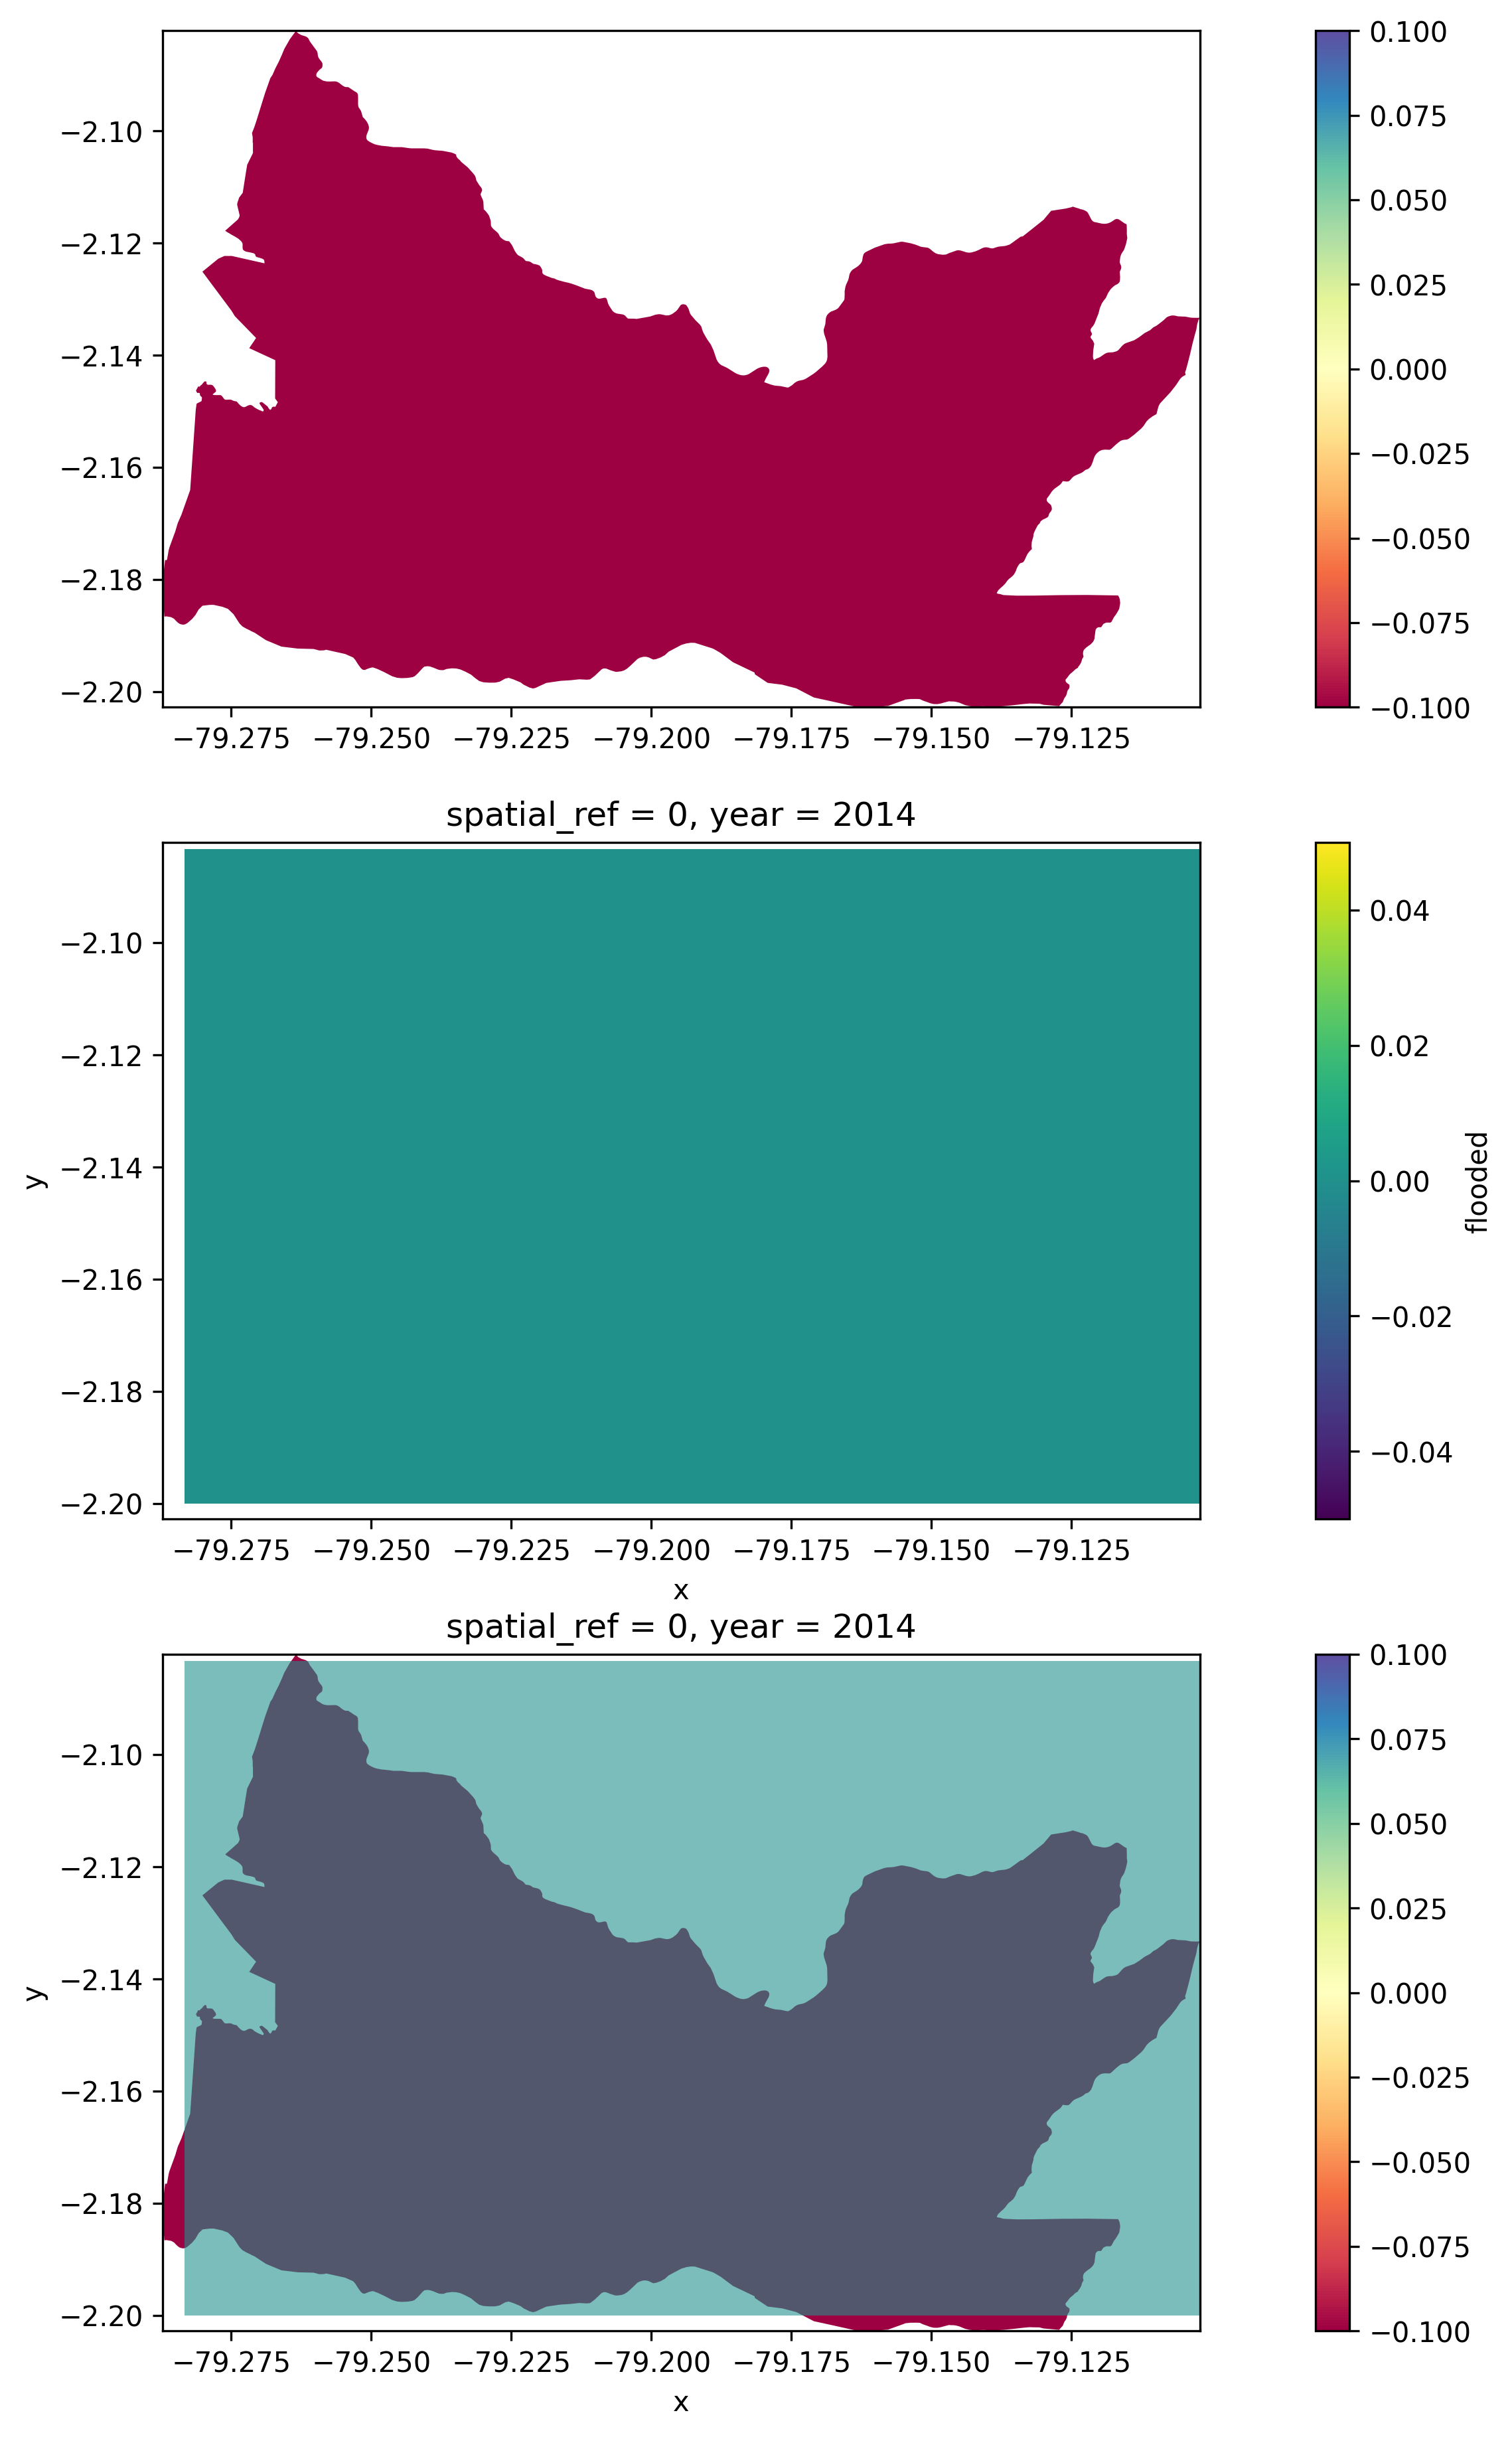

In [73]:
chunk = 5
year = 2014
var = "SPI-1_1_0"

df = pd.read_parquet(rf"D:\World Bank\CLIENT v2\Data\Data_proc\shocks\droughts_{var}_{year}_{chunk}_zonal_stats.parquet")
df = df[df.index == 11800]
gdf = gpd.read_feather(r"E:\client_v2_data\WB_country_IDs.feather")
gdf = gdf[gdf.ID == 11800]
merged = gdf.merge(df, left_on="ID", right_index=True, validate="1:1")
bounds = merged.total_bounds

ds = xr.open_dataset(r"D:\World Bank\CLIENT v2\Data\Data_out\GPW_floods_yearly.nc").rename({"band_data": "flooded"})
ds = ds.sel(x=slice(bounds[0], bounds[2]), y=slice(bounds[3], bounds[1]), year=year)

fig, axs = plt.subplots(3, 1, figsize=(15, 15), dpi=300)

# merged.plot(column="area_affected", ax=axs[1])
merged.plot(column="area_affected", ax=axs[0], legend=True, cmap="Spectral")
merged.plot(column="area_affected", ax=axs[1], legend=False, cmap="Spectral", alpha=0)
merged.plot(column="area_affected", ax=axs[2], legend=True, cmap="Spectral")
ds[f"{var}"].plot(ax=axs[1])
ds[f"{var}"].plot(ax=axs[2], add_colorbar=False, alpha=0.6)

for ax in axs:
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])


In [76]:
merged

,ID,OBJECTID,ADM2_CODE,ADM2_NAME,ADM1_CODE,ADM1_NAME,ADM0_CODE,ADM0_NAME,ADMLAST_CODE,ADMLAST_NAME,geometry,area_affected,cells_affected,total_cells,population_affected,population_affected_n,total_population
11800,11800,20763.0,15426.0,Gnral. Antonio Elizalde,22005,Guayas,73,Ecuador,15426.0,Gnral. Antonio Elizalde,"POLYGON ((-79.20346 -2.13349, -79.20313 -2.133...",0.0,0.0,180,0.0,0.0,11566


In [75]:
ds.flooded.max()

<xarray.DataArray 'flooded' ()> Size: 8B
array(0.)
Coordinates:
    spatial_ref  int32 4B ...
    year         int16 2B 2014

In [ ]:
merged.cx[-100:-90, 35:45].explore(column="area_affected", cmap="Spectral")

In [ ]:
droughts = xr.open_dataset(rf"E:/client_v2_data/ERA5_droughts_1970-2021.nc")
chunk_bounds = (-180, -90, 90, 0)

chunk_droughts = droughts.sel(
    x=slice(chunk_bounds[0], chunk_bounds[2]), y=slice(chunk_bounds[3], chunk_bounds[1])
).load()


In [ ]:
chunk_droughts["drought_SPI-1_1_0"].sel(year=1997).values

In [ ]:
era5 = xr.open_dataset(rf"{DATA_PROC}\ERA5_monthly_1970-2021.nc", chunks={'latitude': 100, 'longitude': 100, 'time': 5})
era5 = era5.rename({'latitude': 'y', 'longitude': 'x'})
era5

In [ ]:
WB_country_grid = xr.open_dataset(rf"{DATA_PROC}\WB_country_grid.nc", chunks={'x': 100, 'y': 100})
WB_country_grid

# Filter these bounds 5.343009,40.639947,20.244439,50.052846
WB_country_grid = WB_country_grid.sel(x=slice(5.343009, 10.244439), y=slice(50.052846, 45.639947))
# era5 = era5.sel(x=slice(5.343009, 10.244439), y=slice(50.052846, 45.639947))

In [ ]:
era5_resamp = era5.interp_like(WB_country_grid, method="nearest")
with ProgressBar():
    era5_resamp = era5_resamp.compute()

In [ ]:
era5_resamp = era5_resamp.chunk({'x': 100, 'y': 100, 'time': 5})

In [ ]:
era5_yearly = era5_resamp["PET"].groupby('time.year').mean()
with ProgressBar():
    era5_yearly = era5_yearly.compute()

In [ ]:
import xrspatial
import dask


tasks = []
era5_yearly = era5_yearly.chunk({"x":100, "y":100, "year":1})
for year in range(1970, 2021):
    era5_year = era5_yearly.sel(year=year).drop_vars("year")
    tasks += [xrspatial.zonal.stats(zones=WB_country_grid.ADM2_CODE, values=era5_year)]
with ProgressBar():
    results = dask.compute(*tasks)#.compute()
# era5_resamp.PET

In [ ]:
out_dict = {year: data.set_index("zone") for year, data in zip(range(1970,2021), results)}
df = pd.concat(out_dict)
df = df.reset_index()
df = df.rename(columns={"level_0":"year"})
df

In [ ]:
WB_country_grid.ADM2_CODE.values.max()

In [ ]:
df.head(30)

In [ ]:
def crop_xarray_by_poygon(dataset, polygon):
    minx, miny, maxx, maxy = polygon.bounds

    dataset = dataset.sel(y=slice(maxy, miny), x=slice(minx, maxx))

    return dataset


def create_carray_mask_from_polygon(dataset, polygon):
    import rasterio

    arr = rasterio.features.geometry_mask(
        [polygon],
        out_shape=(len(dataset.y), len(dataset.x)),
        transform=dataset.rio.transform(),
        invert=True,
    )
    mask = xr.DataArray(
        arr,
        coords={
            "x": dataset.x,
            "y": dataset.y,
        },
        dims=["y", "x"],
    )

    return mask

In [ ]:
# floods = pd.read_csv(rf"{DATA_RAW}\Floods\GloFAS_floods.csv")
population = xr.open_dataset(
    r"Z:\Laboral\World Bank\Vulnerability Index\data\data_in\Grided Population\gpw_v4_population_count_rev11_2020_30_sec.tif"
)  # FIXME: Tendría que usar la del año correspondiente, no la de 2020
population = population.sel(band=1).drop_vars(["band"])

era5 = xr.open_dataset(
    rf"{DATA_OUT}\ERA5_monthly_1970-2021_SPI-SPEI.nc",
    chunks={"latitude": 1000, "longitude": 1000},
)
era5 = era5.rename({"latitude": "y", "longitude": "x"})

In [ ]:
wb_shp = gpd.read_file(rf"{DATA_RAW}\world_bank_adm2.zip")
wb_shp.loc[wb_shp.ADM2_NAME == "Administrative unit not available", "ADM2_CODE"] = (
    np.nan
)
# Create ADM_LAST variable: ADM2_NAME if available, else ADM1_NAME
wb_shp["ADM_LAST"] = wb_shp.ADM2_NAME
wb_shp.loc[wb_shp.ADM_LAST.isnull(), "ADM_LAST"] = wb_shp.ADM1_NAME

In [ ]:
country = wb_shp[wb_shp.ADM0_CODE == 122]

In [ ]:
# Polygon with the country shape
country_polygon = country.unary_union

# Keep only India from population and floods
min_x, min_y, max_x, max_y = country.total_bounds
population = population.sel(y=slice(max_y, min_y), x=slice(min_x, max_x))
era5 = crop_xarray_by_poygon(era5, country_polygon)

# # Interpolate like floods
# era5_resamp = era5.interp_like(population, method="nearest")
# with ProgressBar():
#     era5_resamp = era5_resamp.compute()

In [ ]:
ds = xr.combine_by_coords([population, era5_resamp], combine_attrs="override")
ds = ds.sel(band=1).drop_vars(["band", "spatial_ref"])
ds["x"] = ds["x"].astype("float32")
ds["y"] = ds["y"].astype("float32")
ds = ds.chunk({"y": 1000, "x": 1000})

In [ ]:
ds = ds.chunk({"y": 1000, "x": 1000})

In [ ]:
country_grid[["x", "y"]]

In [ ]:
# Rasterize the country shapes
country_grid = make_geocube(
    vector_data=country[["ADM1_CODE", "ADM2_CODE", "ADM_LAST", "geometry"]],
    like=population,
)
# For some reason, like option is not working, so I have to manually add x and y
assert (country_grid["x"].shape == population["x"].shape)
assert (country_grid["y"].shape == population["y"].shape)
country_grid["x"] = population["x"]
country_grid["y"] = population["y"]

# Combine the population and country grid
ds_geocube = xr.combine_by_coords(
    [
        population,
        country_grid,
    ],
    combine_attrs="override",
)
ds_geocube

In [ ]:
population.band_data.plot()

In [ ]:
pop_by_adm = (
    ds_geocube["band_data"].groupby(ds_geocube["ADM2_CODE"]).sum().to_dataframe()
)
joined = (
    country[["ADM1_CODE", "ADM2_CODE", "ADM_LAST", "geometry"]]
    .set_index("ADM2_CODE")
    .join(pop_by_adm)
)
joined.explore(column="band_data")

In [ ]:
import regionmask

# Create mask of multiple regions from shapefile
eu_mask = regionmask.mask_3D_geopandas(
    country[["ADM2_CODE", "geometry"]].dropna(subset="ADM2_CODE"),
    ds.x,
    ds.y,
    drop=False,
    # numbers="ADM2_CODE"
)
# Apply mask on our dataset
test = ds["SPI-1"].where(eu_mask)
test = test.chunk({"x": 20, "y": 20, "time": 1, "region": 1})

with ProgressBar():
    agg_by_time = (
        test.groupby("region")
        .mean(dim=["x", "y"], method="map-reduce", engine="flox")
        .compute()
    )

In [ ]:
with ProgressBar():
    agg_by_time = test.groupby("region").mean(dim=["x", "y"]).compute()

In [ ]:
test.isel(region=25).plot()

In [ ]:
ds.sel(ADM1_CODE=40544)["SPI-1"].isel(time=30).plot()

In [ ]:
ds.sel(ADM1_CODE=40542)["SPI-1"].isel(time=30).plot()

In [ ]:
ds.groupby("ADM2_CODE")["SPEI-12"]

In [ ]:
ds[["SPI-1", "ADM2_CODE"]]

In [ ]:
ds = ds.sel(band=1).drop(["spatial_ref", "band"])

In [ ]:
# For simplicity, let's say ADM1 is a 2D array with same x, y dimensions
adm1_dim = ds.ADM1_CODE

# Create a new dimension 'adm1' for ADM1 levels
dataset = ds.expand_dims(dim="ADM1_level", axis=2)

# Assign precipitation data to this new dataset structure
dataset["SPI-1"] = dataset["SPI-1"].assign_coords(ADM1_level=adm1_dim)

# Now your dataset has 'x', 'y', and 'ADM1' as dimensions
# (x, y, ADM1_level) structure with precipitation values tagged with corresponding ADM1 codes

# Optionally, if the ADM1 codes are unique and you want to have them as a coordinate dimension:
adm1_unique = adm1_dim.values.flatten()
adm1_unique = np.unique(adm1_unique)

dataset = dataset.assign_coords(ADM1_level=("ADM1_level", adm1_unique))
dataset

In [ ]:
ds_flat = ds.stack(z=("y", "x"))
ds_flat.groupby("ADM1_CODE")["SPI-1"]

In [ ]:
ds.isel(time=30).groupby("ADM1_CODE")  # ["SPI-1"]#.mean(dim=["x", "y"])

In [ ]:
(ds["SPI-1"] * ds.band_data).groupby("ADM2_CODE").sum(dim=("x", "y"))

In [ ]:
# This is OLD
import pandas as pd
from tqdm import tqdm


def compute_share_affected_population(floods, population):

    import numpy as np

    # Calculate affected population for the selected municipality
    population_affected = (floods_resamp * population).sum(dim=("x", "y"))
    area_affected = (floods).sum(dim=("x", "y"))

    # Calculate total population for the selected municipality
    total_population = population.sum(dim=("x", "y"))
    total_area = floods.count(dim=("x", "y"))

    # Calculate share of population affected by floods
    share_population_affected = (
        population_affected / total_population
    ).band_data.values[0]
    share_area_affected = (area_affected / total_area).band_data.values[0]

    # Return value
    return share_population_affected, share_area_affected


def plot_population_vs_floods(floods, population, polygon):
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    floods.rio.clip([polygon]).band_data.plot(ax=ax[0])
    population.rio.clip([polygon]).band_data.plot(ax=ax[1])

    return fig, ax


# Create emty dataframe to store results

if KIND == "DHS":
    admin_name_col = "ADM2_NAME"  # Esto solo si trabajamos con DHS desagregada! FIXME
    admin_code_col = "ADM2_CODE"
    country_map = country_map.dissolve(by="ADM2_CODE").reset_index()
elif KIND == "IPUMS":
    admin_name_col = "ADMIN_NAME"
    admin_code_col = "GEOLEVEL2"

results = pd.DataFrame()
for i in tqdm(range(0, len(country_map))):

    polygon = country_map.geometry[i]

    # Crop xarray to reduce size
    floods_min = crop_xarray_by_poygon(floods, polygon)
    floods_resamp_min = crop_xarray_by_poygon(floods_resamp, polygon)
    population_min = crop_xarray_by_poygon(population, polygon)

    # Clip xarray by poluygon
    floods_min = floods_min.where(create_carray_mask_from_polygon(floods_min, polygon))
    floods_resamp_min = floods_resamp_min.where(
        create_carray_mask_from_polygon(floods_resamp_min, polygon)
    )
    population_min = population_min.where(
        create_carray_mask_from_polygon(population_min, polygon)
    )

    # plot_population_vs_floods(floods, population, polygon)
    share_pop_affected, share_area_affected = compute_share_affected_population(
        floods_min, floods_resamp_min, population_min
    )

    # add to dataframe
    results.loc[i, admin_name_col] = country_map[admin_name_col][i]
    results.loc[i, admin_code_col] = country_map[admin_code_col][i]
    results.loc[i, "POP_PERCENT_AFFECTED"] = share_pop_affected * 100
    results.loc[i, "AREA_PERCENT_AFFECTED"] = share_area_affected * 100

results

In [ ]:
ds = (
    xr.combine_by_coords([population, era5_resamp])
    .rename({"band_data": "POPULATION"})
    .sel(band=1)
)

In [ ]:
# ds["drought_spi1_2"] =
ds["drought"] = ds["SPI-1"] < -0.5

In [ ]:
def calculate_per_municipality(ds, geom):
    population_affected = (ds.drought * ds.POPULATION.where(geom)).sum(dim=("x", "y"))
    # area_affected = (ds..where(geom)).sum(dim=('x', 'y'))
    # total_population = population_min.where(geom).sum(dim=('x', 'y'))
    # total_area = ds.where(geom).count(dim=('x', 'y'))

    # share_population_affected = (population_affected / total_population).data[0]
    # share_area_affected = (area_affected / total_area).data[0]
    return population_affected  # share_population_affected, share_area_affected


calculate_per_municipality(ds, country.geometry[0])

In [ ]:
import xarray as xr


# Assuming your geodataframe's geometry column is called 'geometry'
def vectorized_calculation(ds, polygon):
    # 1. Use xr.apply_ufunc with a custom function for municipality-wise calculation
    def calculate_per_municipality(ds, geom):
        population_affected = (ds.drought * population_min.where(geom)).sum(
            dim=("x", "y")
        )
        # area_affected = (ds..where(geom)).sum(dim=('x', 'y'))
        # total_population = population_min.where(geom).sum(dim=('x', 'y'))
        # total_area = ds.where(geom).count(dim=('x', 'y'))

        # share_population_affected = (population_affected / total_population).data[0]
        # share_area_affected = (area_affected / total_area).data[0]
        return population_affected  # share_population_affected, share_area_affected

    # Crop xarray to reduce size
    ds = crop_xarray_by_poygon(ds, polygon)
    ds = ds.where(create_carray_mask_from_polygon(ds, polygon))

    # 2. Apply the function along the geometry dimension with vectorized operations
    results = xr.apply_ufunc(ds, polygon, vectorize=True)

    return results


# Call the function with the geodataframe geometry
share_pop_affected, share_area_affected = vectorized_calculation(ds, country.geometry)

In [ ]:
import pandas as pd

pd.options.plotting.backend = "plotly"

results.PERCENT_AFFECTED.plot()

In [ ]:
# population.to_netcdf("pop_india.nc")ds.rio.write_crs("epsg:4326", inplace=True)
floods_resamp = floods_resamp.sortby(["y", "x", "band"])
floods_resamp.rio.write_crs("epsg:4326")
floods_resamp.band_data.rio.to_raster("floods_india.tif")

In [ ]:
def plot_treatment(india_map, results):

    india_map.merge(results, on="ADM2_CODE", how="inner").plot(
        column="TREATED", legend=True
    )

    return


plot_treatment(country_map, results)